In [44]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Problem 1: Gaussian and Laplacian pyramids.

In [45]:
'''
a) Write functions gaussian_pyramid and laplacian_pyramid that decompose an input grayscale image into a J-level Gaussian and Laplacian pyramid, respectively,
where J is an input to each function. You can use cv2.resize for downsampling and upsampling with INTER_LINEAR and
INTER_CUBIC filters, respectively.
'''
def gaussian_pyramid(image, J):
    # gaussian pyramid with step J
    pyramid = [image]
    for i in range(J):
        image = cv2.resize(image, (image.shape[1] // 2, image.shape[0] // 2), interpolation=cv2.INTER_LINEAR)
        pyramid.append(image)
    return pyramid

In [46]:
def laplacian_pyramid(image, J):
    # laplacian pyramid with step J
    gauss = gaussian_pyramid(image, J)
    pyramid = []
    for i in range(J):
        expanded = cv2.resize(gauss[i+1], (gauss[i].shape[1], gauss[i].shape[0]), interpolation=cv2.INTER_CUBIC)
        lap = cv2.subtract(gauss[i], expanded)
        pyramid.append(lap)
    pyramid.append(gauss[-1])
    return pyramid

In [47]:
'''
b) Write a function reconstruct_laplacian that reconstructs the original image from
a J-level Laplacian pyramid. Verify it works correctly on a test image. Display the
Gaussian and Laplacian pyramid images for J = 3 (Results below)
'''
def reconstruct_laplacian(pyramid):
    # reconstruct image from a laplacian pyramid
    image = pyramid[-1]
    for i in range(len(pyramid) - 2, -1, -1):
        image = cv2.resize(image, (pyramid[i].shape[1], pyramid[i].shape[0]), interpolation=cv2.INTER_LINEAR)
        image = cv2.add(image, pyramid[i])
    return image

Text(0.5, 1.0, 'Reconstructed Image')

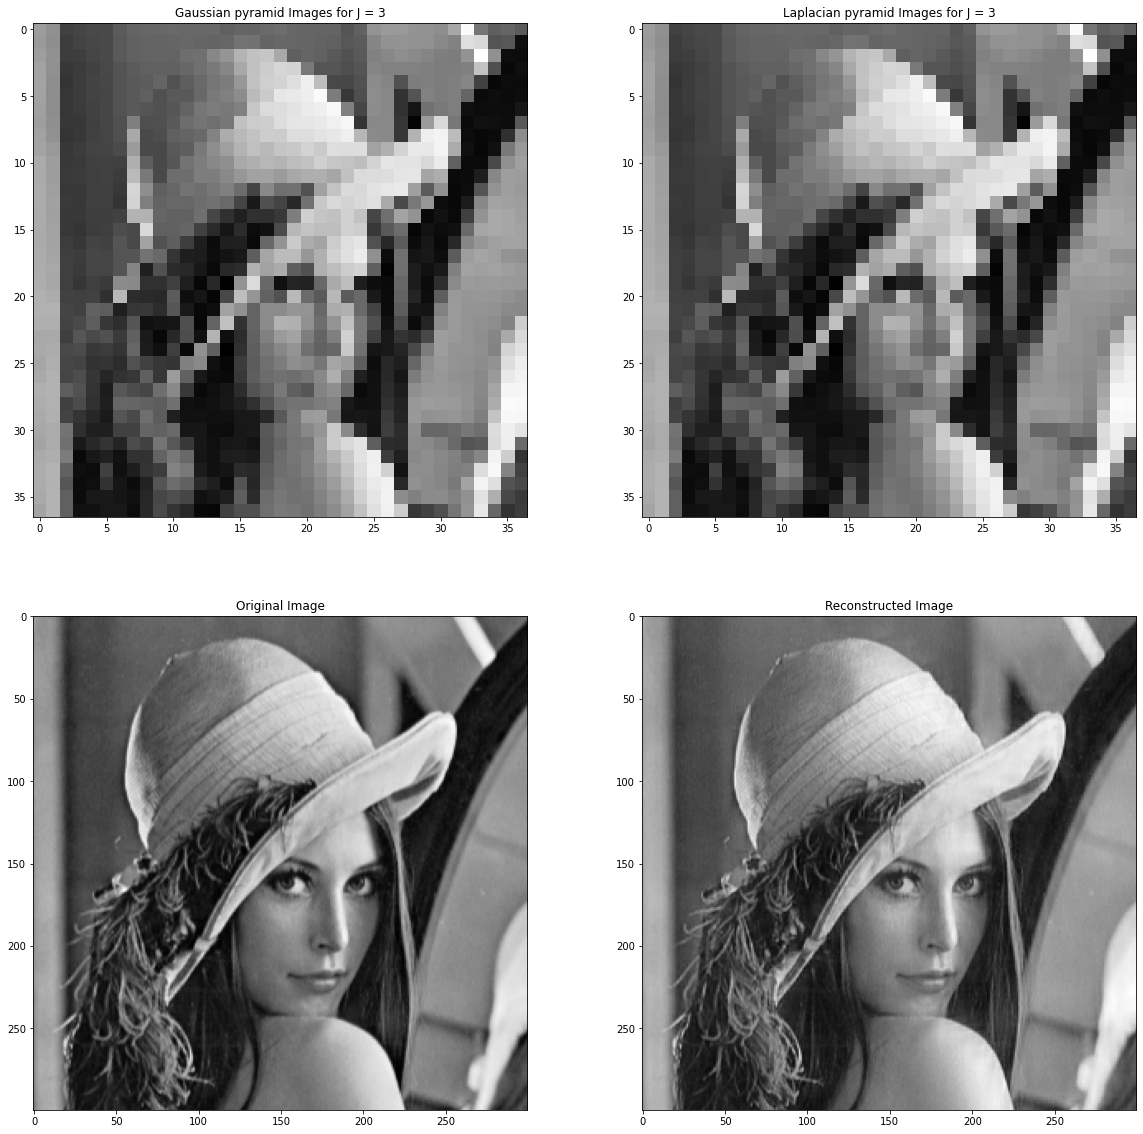

In [48]:
'''
a)+b) test
'''
# Load the test image
image = cv2.imread('lena.png', cv2.IMREAD_GRAYSCALE).astype(float)

# Global
J = 3
q = 70
gauss = gaussian_pyramid(image, J)
lap = laplacian_pyramid(image, J)
reconstructed = reconstruct_laplacian(lap)

b,plot1 = plt.subplots(2,2,figsize=(20,20))
plot1[0][0].imshow(gauss[3],cmap='gray') 
plot1[0][0].set_title("Gaussian pyramid Images for J = 3")
plot1[0][1].imshow(lap[3],cmap='gray')
plot1[0][1].set_title("Laplacian pyramid Images for J = 3")
plot1[1][0].imshow(image,cmap='gray') 
plot1[1][0].set_title('Original Image')
plot1[1][1].imshow(reconstructed,cmap='gray') 
plot1[1][1].set_title('Reconstructed Image')

Gaussian and Laplacian pyramid images for J = 3, the original and reconstructed image are shown above. 

In [49]:
'''
PSNR calculation helper for d)
'''
def PSNR(o_image, n_image):
    ## From my last CA2
    # # #resize because for the denoise image have a different dimension.
    n_image = cv2.resize(n_image, (o_image.shape[1], o_image.shape[0]))
    # # #from 0 to 1 to use the formula given in the question
    o_image = o_image/255
    n_image = n_image/255
    err = np.sum((o_image.astype("float") - n_image.astype("float")) ** 2)
    MSE = err/(float(o_image.shape[0] * o_image.shape[1]))
    return (-10*np.log10(MSE))

In [50]:
'''
c)
'''
def quantize_experiment(image, q, J):
    # function to get reconstructed image into an array
    nnz = 0
    # get the laplacian pyramid
    pyramid = laplacian_pyramid(image, J)
    for i in range(len(pyramid)):
        # Determine the mean value of the coefficient map, based on the question
        if i == len(pyramid) - 1:
            # (residual Laplacian image)
            u = 0
        else: # others
            u = 128
        # Based on the formula
        pyramid[i] = q*np.floor((pyramid[i]-u)/q+ 0.5) + u
    
    #count 0s
    nnz = np.sum([np.count_nonzero(level) for level in pyramid])
    # get image from pyramid
    reconstructed_img = reconstruct_laplacian(pyramid)
    # calculate psnr
    psnr = PSNR(image, reconstructed_img)
    return reconstructed_img, nnz, psnr

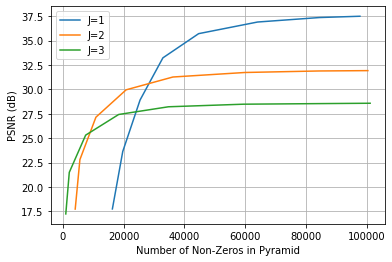

In [51]:
'''
d) Plot PSNR on the y-axis and NNZ on the x-axis.
'''
n = 8
#for each j value from 0 to 3 with 0 as the original image
J = [1,2,3]
num = []
psnr = []
quantization_steps = [2**(i) for i in range(n)]
for j in J:
    original_psnr = []
    non_zeros = []
    for i in range(len(quantization_steps)):
        _, n, p = quantize_experiment(image,quantization_steps[i],j)
        original_psnr.append(p)
        non_zeros.append(n)
    psnr.append(original_psnr)
    num.append(non_zeros)

for i, J in enumerate(J):
    plt.plot(num[i], psnr[i], label=f'J={J}')

plt.xlabel('Number of Non-Zeros in Pyramid')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.grid()
plt.show()

- When the depth of the pyramid J, the representation becomes more efficient in terms of compression. We can achieve a higher compression ratio (fewer non-zero coefficients) while maintaining a desired reconstruction PSNR. This is expected because deeper pyramids capture more significant image details, allowing us to represent the image using fewer coefficients.

- J=1 performs the best out of all pyramids also shows that the relationship between depth and representation efficiency can be content-dependent. Some images may benefit from deeper pyramids to maintain PSNR, while simpler images may achieve the same PSNR with shallower pyramids.

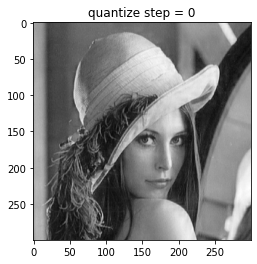

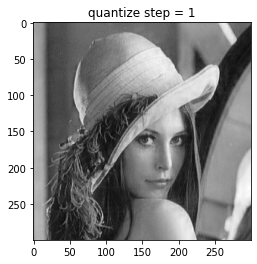

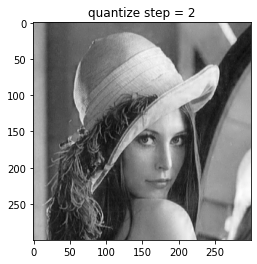

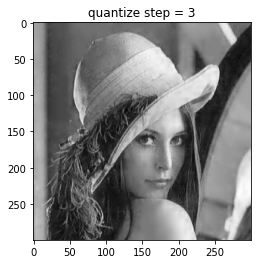

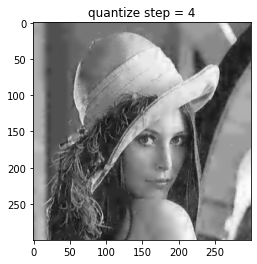

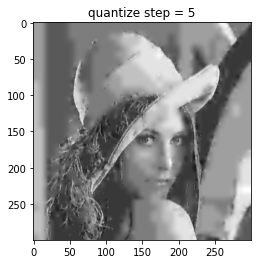

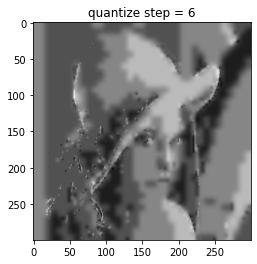

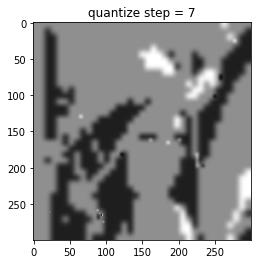

In [52]:
'''
e) For J = 3, determine qualitatively at what point the quantization level is unnoticeable. How do the number of non-zeros compare to the original image?
'''
n = 8
J = 3
num = np.zeros(n)
psnr = np.zeros(n)
quantization_steps = [2**(i) for i in range(n)]
rec_img = np.zeros([n, image.shape[0], image.shape[1]])
for i in range(n):
    rec_img[i], num[i], psnr[i] = quantize_experiment(image,quantization_steps[i],J)
    plt.imshow(rec_img[i],cmap='gray')
    plt.title('quantize step = {}'.format(i))
    plt.show()


As shown above, the quantization level is unnoticeable around step 3 (step 2 in the graph). The number of non zeros is the following.

In [53]:
non_zeros = np.count_nonzero(image-rec_img[2])
psnr = PSNR(image, rec_img[2])
ori = np.count_nonzero(image)
print(non_zeros, ori, psnr)

89929 90000 28.486710372707623
